In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq
import dict_minimize
from pytictoc import TicToc

import bvbq

# import bvbq.gp
# import bvbq.bvi
# import bvbq.distributions

W0807 19:17:20.134869 140334712481600 xla_bridge.py:137] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
key1 = jax.random.PRNGKey(250)
key2,_ = jax.random.split(key1)
mixmeans_test = 4*jax.random.normal(key1,shape=(12,1))
# mixmeans_test = jnp.ones((12,1))
mixmeans_test = jnp.array([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = jnp.ones((12,1))
mixweights_test = jnp.ones(12)/12
# mixmeans_test = jnp.array([[3.0],[-3.0]])
# mixvars_test = jnp.ones((2,1))
# mixweights_test = jnp.ones(2)/2
# bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights)

In [4]:
def logprob_mixgaussians(x):
    return bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = jnp.linspace(-20,20,51).reshape(-1,1)
# ydata = logprob_t(xdata,2.5)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq.gp.SimpleGP(1,kind='sqe',noise=0,zeromax=True)
logprobgp.mean = -10.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
# logprobgp.optimize_params()

-2.0309572
--


ValueError: jitted function has static_argnums=(4, 5), donate_argnums=() but was called with only 2 positional arguments.

In [ ]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
plt.hist(samples1.flatten(),density=True,bins=100);

In [ ]:
def mcbq_dmvn_elbo(logprobgp,mean,var,nsamples):
    term1 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var))
    term2 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False)
    return term1 + term2
#     term1 = distrib.monte_carlo_entropy(nsamples)
#     term2 = bq.monte_carlo_bayesian_quadrature(logprobgp,distrib,nsamples)
#     return term1 + term2

def objective_function_elbo(params):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_elbo(logprobgp,mean,var,1000)
    return res

In [ ]:
params = {'mean':jnp.zeros(1)-1.0,'rawvar':jnp.zeros(1)}
jax.value_and_grad(objective_function_elbo)(params)
maxiter = 100
alpha = 1e-1
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha)
func_and_grad_elbo = jax.value_and_grad(objective_function_elbo)
optwrapper.init(params,func_and_grad_elbo)
for k in range(maxiter):
    value,grads = optwrapper.step()
    params = optwrapper.params
#     print(value,params['mean'],jax.nn.softplus(params['rawvar']))
mean,rawvar = params['mean'],params['rawvar']
var = jax.nn.softplus(rawvar)
distrib = bvbq.distributions.DiagonalNormalDistribution(mean,var)

In [ ]:
xplot = np.linspace(-10,10,201).reshape(-1,1)
# yplot1 = logprob_t(xplot,2.5)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = distrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(10000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
samples3 = distrib.sample(10000)
plt.hist(samples1.flatten(),density=True,bins=100,alpha=0.5,color='blue');
plt.hist(samples3.flatten(),density=True,bins=100,alpha=0.5,color='green');

In [ ]:
# bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                         x,mixmeans_test,mixvars_test,mixweights_test)


In [5]:
data = np.load('/home/danilo/Temp/TestBVBQ/data.npz')
data2 = np.load('/home/danilo/Temp/TestBVBQ/data2.npz')

In [184]:
logprobgp = bvbq.gp.SimpleGP(1,kind='smatern32',noise=0,zeromax=True)
logprobgp.mean = data['gpmean']
logprobgp.noise = data['noise']
logprobgp.lengthscale = data['lengthscale']
logprobgp.theta = data['outputscale']
logprobgp.set_data(data['X'],data['y'].flatten(),empirical_params=False)

-2.0309563
--


In [189]:
x = jnp.array([[1.0],[2.0]])
%timeit logprobgp.predict(x,return_cov=True)

11.8 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [180]:
samples = jnp.sqrt(data['var'])*data['zsamples'] + data['mean']
r1 = -bvbq.distributions.MixtureDiagonalNormalDistribution.\
     logprob_(samples,data['mixmeans'],data['mixvars'],data['mixweights']).mean()
# r1 = bvbq.utils.logbound(r1,data['stabilizer'])
r2 = data['term2'].mean()
print(jnp.abs(r1 - r2)/jnp.abs(r1))
# data2 = np.load('/home/danilo/Temp/TestBVBQ/data2.npz')

8.414944e-08


In [181]:
def mcbq_dmvn_relbo_test(logprobgp,mean,var,mixmeans,mixvars,mixweights,
                         zsamples,logdelta=-20,reg=1e-2):
#     subkey,key = jax.random.split(key)
#     samples = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkey)
    tictoc = TicToc()
    samples = jnp.sqrt(var)*zsamples+mean
    tictoc.tic()
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) #Variance
    tictoc.toc()
#     print(mixmeans,mixvars,mixweights)
#     term2 = bvbq.utils.lb_mvn_mixmvn_cross_entropy(mean,var,mixmeans,mixvars,mixweights,logdelta)
    tictoc.tic()
    term2 = -bvbq.utils.logbound(
                bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights),
                logdelta).mean()
    tictoc.toc()
#     term2 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights).mean()
    tictoc.tic()
    term3 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var)) #Entropy
    tictoc.toc()
    return term1,term2,term3
mcbq_dmvn_relbo_test(logprobgp,data['mean'],data['var'],data['mixmeans'],data['mixvars'],data['mixweights'],
                     data['zsamples'],reg=1e-2)

Elapsed time is 0.016379 seconds.
Elapsed time is 0.000806 seconds.
Elapsed time is 0.000773 seconds.


(DeviceArray(-2.533722, dtype=float32),
 DeviceArray(2.8332758, dtype=float32),
 DeviceArray(1.6835561, dtype=float32))

In [169]:
data['term2']

array(2.8332756, dtype=float32)

In [137]:
def mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,
                    key,nsamples=1000,logdelta=-10,reg=1e-2):
    subkey,key = jax.random.split(key)
    samples = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkey)
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) #Variance
#     print(mixmeans,mixvars,mixweights)
#     term2 = bvbq.utils.lb_mvn_mixmvn_cross_entropy(mean,var,mixmeans,mixvars,mixweights,logdelta)
    term2 = -bvbq.utils.logbound(
                bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights),
                logdelta).mean()
#     term2 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights).mean()
    term3 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var)) #Entropy
    return term1 + term2 + reg*term3

def mcbq_mixdmvn_gradboost_elbo(logprobgp,weight,mean,var,
                                mixmeans,mixvars,mixweights,
                                key,nsamples=1000):
    mixmeans_up = jnp.vstack([mixmeans,mean])
    mixvars_up = jnp.vstack([mixvars,var])
    mixweights_up = jnp.append((1-weight)*mixweights,weight)
    term1 = bvbq.bq.separable_mixdmvn_bq(logprobgp,mixmeans_up,
                                         mixvars_up,mixweights_up,
                                         return_var=False)
    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)
    samples2 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(nsamples,
                                                                            mixmeans,
                                                                            mixvars,
                                                                            mixweights,
                                                                            subkeya,subkeyb)
    samples3 = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkeyc)
    term2 = -(1-weight)*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples2,mixmeans_up,mixvars_up,mixweights_up).mean()
    term3 = -weight*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples3,mixmeans_up,mixvars_up,mixweights_up).mean()
    return term1 + term2 + term3
#     term2 = weight*bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False)
#     subkey1,key = jax.random.split(key)
#     subkey2,key = jax.random.split(key)
#     samples3 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(nsamples,
#                                                                             mixmeans,
#                                                                             mixvars,
#                                                                             mixweights,
#                                                                             subkey1,subkey2)
#     subkey3,key = jax.random.split(key)
#     samples4 = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkey)
#     mixmeans_up = jnp.vstack([mixmeans,mean])
#     mixvars_up = jnp.vstack([mixvars,var])
#     mixweights_up = jnp.append((1-weight)*mixweights,weight)
#     term3 = -(1-weight)*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples3,mixmeans_up,mixvars_up,mixweights_up).mean()
#     term4 = -weight*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples4,mixmeans_up,mixvars_up,mixweights_up).mean()
# #     term3 = -(1-weight)*join_distributions(samples3,weight,mean,var,mixmeans,mixvars,mixweights).mean()
# #     term4 = -weight*join_distributions(samples4,weight,mean,var,mixmeans,mixvars,mixweights).mean()
#     return term1 + term2 + term3 + term4

def join_distributions(samples,weight,mean,var,mixmeans,mixvars,mixweights):
    terma = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights)
    termb = bvbq.distributions.DiagonalNormalDistribution.logprob_(
                    samples,mean,var)
    term = bvbq.utils.logsumexp(jnp.stack([terma,termb],axis=-1),
                                weights=jnp.array([1.-weight,weight]),
                                axis=-1)
    return term

In [153]:
def objective_function_relbo(params,mixmeans,mixvars,mixweights,key):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,key,
                           nsamples=100,logdelta=-10,reg=1e0)
    return res

def objective_function_gradboost(weight,mean,var,
                                 mixmeans,mixvars,mixweights,
                                 key):
    res = -mcbq_mixdmvn_gradboost_elbo(logprobgp,weight,mean,var,
                                mixmeans,mixvars,mixweights,
                                key,nsamples=100)
    return res

func_and_grad_relbo = jax.value_and_grad(objective_function_relbo,argnums=0)
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost,argnums=0)

In [160]:
scipy.stats.halfnorm.rvs(size=(1,))

array([1.10004099])

In [162]:
bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(1,mixmeans,mixvars,mixweights,subkeya,subkeyb)[0]

DeviceArray([-21.02821], dtype=float32)

In [ ]:
#log(1+exp(x)) = y -> exp(x) = log(1-exp(y))

In [166]:
# mean,var = distrib.params
# mixmeans = mean.reshape(1,-1)
# mixvars = var.reshape(1,-1)
dim = 1
mean = jnp.zeros((dim,))
var = (20.0/3)**2*jnp.ones((dim,))
mean,var = distrib.params
mixmeans = jnp.expand_dims(mean,-1)
mixvars = jnp.expand_dims(var,-1)*12
mixweights = jnp.ones(1)

alpha_relbo = 1e-3
maxiter_relbo = 300
alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 10
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha_relbo)

key = jax.random.PRNGKey(100)

tictoc = TicToc()
for k in range(maxiter):
    tictoc.tic()
    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)
    mean_init = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(
                    1,mixmeans,mixvars,mixweights,subkeya,subkeyb)[0]
    var_init = jnp.array(scipy.stats.halfnorm.rvs(size=(1,)),dtype=jnp.float32)
    rawvar_init = jnp.log(1-jnp.exp(var_init))
    params = {'mean':mean_init,
              'rawvar':rawvar_init}
    optwrapper.init(params,func_and_grad_relbo)
    for i in range(maxiter_relbo):
        value,grads = optwrapper.step(mixmeans,mixvars,mixweights,subkey)
        params = optwrapper.params
    tictoc.toc()
    raise KeyError
#     subkeya,key = jax.random.split(key)
#     subkeyb,key = jax.random.split(key)

#     params = {'mean':jnp.array(np.random.normal(size=(dim,))),
#               'var':jnp.exp(jnp.array(np.random.normal(size=(dim,))))}
#     params = collections.OrderedDict(params)
#     lb_dict = collections.OrderedDict({'mean':(-1e10,)*dim,'var':(1e-6,)*dim})
#     ub_dict = collections.OrderedDict({'mean':(1e10,)*dim,'var':(1e10,)*dim})
#     res = dict_minimize.jax_api.minimize(func_and_grad_relbo, params,
#                                          args=(mixmeans,mixvars,mixweights,subkey),
#                                          method='L-BFGS-B',
#                                          lb_dict=lb_dict,
#                                          ub_dict=ub_dict,
#                                          tol=1e-6)
# #     raise KeyError
#     mean,var = params['mean'],params['var']
#     mean = jnp.ones((1,));var=jnp.ones((1,))
    weight = 1e-4
    for i in range(maxiter_boost):
        subkey,key = jax.random.split(key)
        res,gradweight = func_and_grad_gradboost(weight,mean,var,mixmeans,mixvars,mixweights,subkey)
#         weight = -alpha_boost*(i/10+1)**(-0.55)*gradweight
        weight -= alpha_boost*gradweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-4:
            break
#     mixdistrib.add_component(mean,var,weight)
    mixweights = jnp.append((1-weight)*mixweights,weight)
    mixmeans = jnp.vstack([mixmeans,mean])
    mixvars = jnp.vstack([mixvars,var])
    print(k,mean,var,weight)
    print('--')
    

Elapsed time is 22.275054 seconds.


KeyError: 

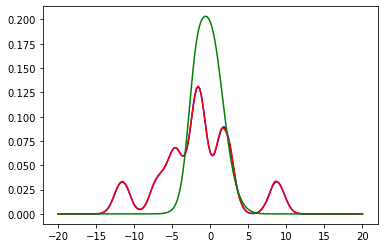

In [31]:
boostdistrib = bvbq.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = boostdistrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')

In [28]:
mixweights

DeviceArray([1.2771407e-07, 3.6267576e-07, 2.1198957e-05, 1.6730334e-07,
             2.1850838e-01, 2.1855207e-05, 2.1857393e-05, 2.1859580e-05,
             2.1861768e-05, 1.7548002e-01, 3.9413710e-05, 1.1455228e-01,
             4.9111062e-01, 9.9989993e-05, 9.9999997e-05], dtype=float32)